In [1]:
# Library Imports 

import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from RAKE import rake
import seaborn as sns
import matplotlib.pyplot as plt
rake = rake.Rake("RAKE/SmartStoplist.txt")
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from scipy import spatial


def printmd(string):
    display(Markdown(string))

% matplotlib inline

## Business Data

In [2]:
business = pd.read_json('./Data/business.json', lines =  True)
#business = pd.read_pickle('business.pkl')

print(business.shape)


# Only open businesses & with categories
business = business[business.is_open == 1]
business.drop(columns = ['address','is_open', 'latitude', 'longitude'], inplace = True)
business = business[business.categories.apply(len) != 0]

business.head()

(174567, 15)


,attributes,business_id,categories,city,hours,name,neighborhood,postal_code,review_count,stars,state
0,"{'AcceptsInsurance': True, 'ByAppointmentOnly'...",FYWN1wneV18bWNgQjJ2GNg,"[Dentists, General Dentistry, Health & Medical...",Ahwatukee,"{'Friday': '7:30-17:00', 'Tuesday': '7:30-17:0...",Dental by Design,,85044,22,4.0,AZ
1,"{'BusinessParking': {'garage': False, 'street'...",He-G7vWjzVUysIKrfNbPUQ,"[Hair Stylists, Hair Salons, Men's Hair Salons...",McMurray,"{'Monday': '9:00-20:00', 'Tuesday': '9:00-20:0...",Stephen Szabo Salon,,15317,11,3.0,PA
2,{},KQPW8lFf1y5BT2MxiSZ3QA,"[Departments of Motor Vehicles, Public Service...",Phoenix,{},Western Motor Vehicle,,85017,18,1.5,AZ
4,"{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",PfOCPjBrlQAnz__NXj9h_w,"[American (New), Nightlife, Bars, Sandwiches, ...",Cuyahoga Falls,"{'Monday': '11:00-1:00', 'Tuesday': '11:00-1:0...",Brick House Tavern + Tap,,44221,116,3.5,OH
5,"{'GoodForMeal': {'dessert': False, 'latenight'...",o9eMRCWt5PkpLDE0gOPtcQ,"[Italian, Restaurants]",Stuttgart,"{'Monday': '18:00-0:00', 'Tuesday': '18:00-0:0...",Messina,,70567,5,4.0,BW


In [3]:
print('Size : ',business.shape)
display(business.info())

Size :  (146226, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 146226 entries, 0 to 174566
Data columns (total 11 columns):
attributes      146226 non-null object
business_id     146226 non-null object
categories      146226 non-null object
city            146226 non-null object
hours           146226 non-null object
name            146226 non-null object
neighborhood    146226 non-null object
postal_code     146226 non-null object
review_count    146226 non-null int64
stars           146226 non-null float64
state           146226 non-null object
dtypes: float64(1), int64(1), object(9)
memory usage: 13.4+ MB


None

## Review Data

In [4]:
# Takes a lot of time to read
review = pd.DataFrame()

df = pd.read_json('./Data/review.json',lines = True, chunksize= 1e5)

try:
   for df_chunk in df:
       review = pd.concat([review, df_chunk])
except ValueError:
       print ('\nSome messages in the file cannot be parsed')

review.drop(columns = ['cool','funny'], inplace = True)

print(review.shape)

review.head()

(5261669, 7)


,business_id,date,review_id,stars,text,useful,user_id
0,0W4lkclzZThpx3V65bVgig,2016-05-28,v0i_UHJMo_hPBq9bxWvW4w,5,"Love the staff, love the meat, love the place....",0,bv2nCi5Qv5vroFiqKGopiw
1,AEx2SYEUJmTxVVB18LlCwA,2016-05-28,vkVSCC7xljjrAI4UGfnKEQ,5,Super simple place but amazing nonetheless. It...,0,bv2nCi5Qv5vroFiqKGopiw
2,VR6GpWIda3SfvPC-lg9H3w,2016-05-28,n6QzIUObkYshz4dz2QRJTw,5,Small unassuming place that changes their menu...,0,bv2nCi5Qv5vroFiqKGopiw
3,CKC0-MOWMqoeWf6s-szl8g,2016-05-28,MV3CcKScW05u5LVfF6ok0g,5,Lester's is located in a beautiful neighborhoo...,0,bv2nCi5Qv5vroFiqKGopiw
4,ACFtxLv8pGrrxMm6EgjreA,2016-05-28,IXvOzsEMYtiJI0CARmj77Q,4,Love coming here. Yes the place always needs t...,0,bv2nCi5Qv5vroFiqKGopiw


In [5]:
review.columns = ['business_id', 'date', 'review_id', 'review_stars', 'text', 'useful','user_id']
review['review_length'] = review.text.apply(len)
review.columns

Index(['business_id', 'date', 'review_id', 'review_stars', 'text', 'useful',
       'user_id', 'review_length'],
      dtype='object')

In [6]:
review.describe()

,review_stars,useful,review_length
count,5.261669e+06,5.261669e+06,5.261669e+06
mean,3.727740e+00,1.385085e+00,6.116914e+02
std,1.433593e+00,4.528727e+00,5.719504e+02
min,1.000000e+00,-1.000000e+00,1.000000e+00
25%,3.000000e+00,0.000000e+00,2.420000e+02
50%,4.000000e+00,0.000000e+00,4.340000e+02
75%,5.000000e+00,2.000000e+00,7.800000e+02
max,5.000000e+00,3.364000e+03,5.000000e+03


In [7]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5261669 entries, 0 to 5261668
Data columns (total 8 columns):
business_id      object
date             datetime64[ns]
review_id        object
review_stars     int64
text             object
useful           int64
user_id          object
review_length    int64
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 321.1+ MB


## Check-In Data

In [8]:
checkin = pd.read_json('./Data/checkin.json', lines = True)
#checkin = pd.read_pickle('checkin.pkl')
print(checkin.shape)
checkin.head()

(146350, 2)


,business_id,time
0,7KPBkxAOEtb3QeIL9PEErg,"{'Thursday': {'21:00': 4, '1:00': 1, '4:00': 1..."
1,kREVIrSBbtqBhIYkTccQUg,"{'Monday': {'13:00': 1}, 'Thursday': {'20:00':..."
2,tJRDll5yqpZwehenzE2cSg,"{'Monday': {'12:00': 1, '1:00': 1}, 'Friday': ..."
3,r1p7RAMzCV_6NPF0dNoR3g,"{'Thursday': {'23:00': 1}, 'Saturday': {'21:00..."
4,mDdqgfrvROGAumcQdZ3HIg,"{'Monday': {'12:00': 1, '21:00': 1}, 'Wednesda..."


## User Data

In [9]:
user = pd.read_json('./Data/user.json', lines = True)
#user = pd.read_pickle('user.pkl')

user_columns_to_remove = ['compliment_cool', 'compliment_cute',
       'compliment_funny', 'compliment_hot', 'compliment_list',
       'compliment_more', 'compliment_note', 'compliment_photos',
       'compliment_plain', 'compliment_profile', 'compliment_writer',
       'cool','fans', 'friends', 'funny',
       'useful', 'yelping_since']
user.drop(columns = user_columns_to_remove, inplace = True)

user.elite = user.elite.apply(lambda x: 0 if len(x) == 0 else 1)
elite_user_id = user[user.elite == 1].user_id.values
print(user.shape)
user.head()

(1326101, 5)


,average_stars,elite,name,review_count,user_id
0,4.67,0,Johnny,8,oMy_rEb0UBEmMlu-zcxnoQ
1,3.70,0,Chris,10,JJ-aSuM4pCFPdkfoZ34q0Q
2,2.00,0,Tiffy,1,uUzsFQn_6cXDh6rPNGbIFA
3,4.67,0,Mark,6,mBneaEEH5EMyxaVyqS-72A
4,4.67,0,Evelyn,3,W5mJGs-dcDWRGEhAzUYtoA


In [10]:
user.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1326101 entries, 0 to 1326100
Data columns (total 5 columns):
average_stars    1326101 non-null float64
elite            1326101 non-null int64
name             1326101 non-null object
review_count     1326101 non-null int64
user_id          1326101 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 60.7+ MB


## Using only half the data

In [11]:
# # train_test_split
# business, _ = train_test_split(business, test_size = 0.5)
# review, _ = train_test_split(review, test_size = 0.5)
# user, _ = train_test_split(user, test_size = 0.5)

# Exploratory Data Analysis

## Distribution of Reviews

In [12]:
dist_reviews = review.user_id.value_counts().value_counts()

Text(0.5,0,'Number of reviews')

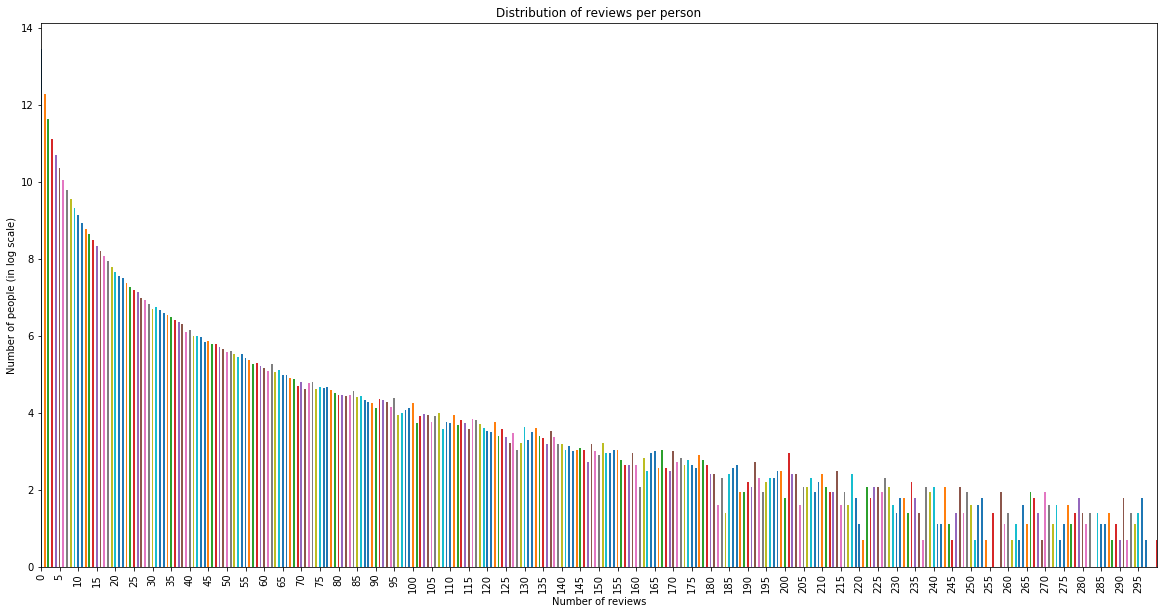

In [13]:
ax = np.log(dist_reviews).sort_index().plot(kind = 'bar', title = 'Distribution of reviews per person', figsize = (20,10))


ax.set_xlim(0, 300)
ax.set_xticklabels(np.arange(0, 300, 5))
ax.xaxis.set_ticks(np.arange(0, 300, 5))
ax.set_ylabel("Number of people (in log scale)")
ax.set_xlabel("Number of reviews")

Text(0.5,0,'Number of reviews')

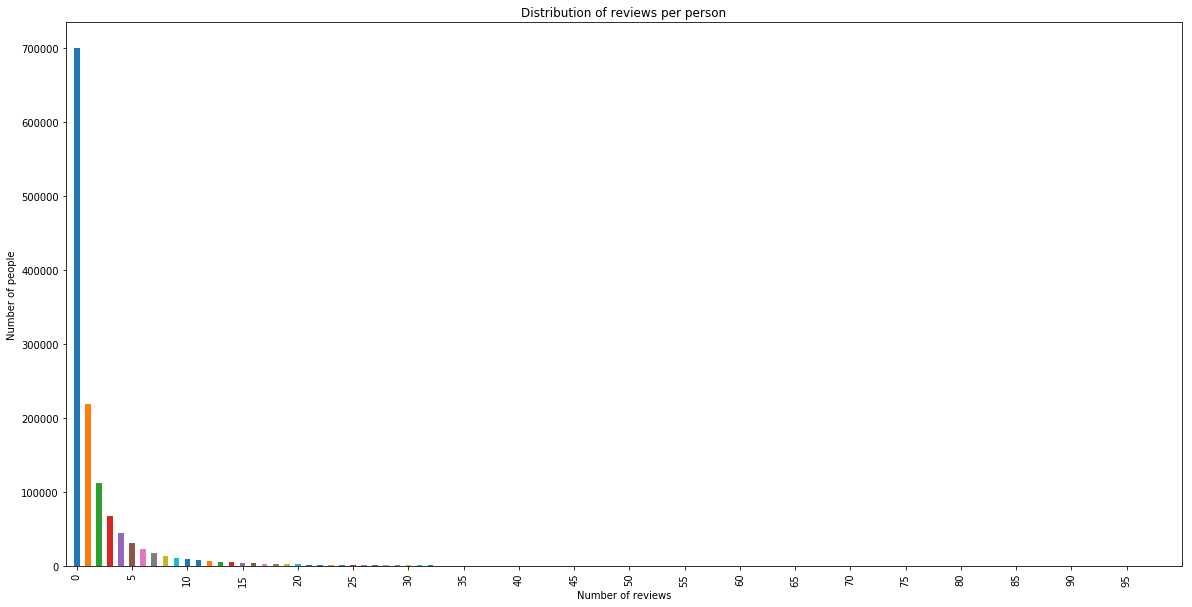

In [35]:
ax = dist_reviews.sort_index().plot(kind = 'bar', title = 'Distribution of reviews per person', figsize = (20,10))
ax.set_xlim(-1, 100)
ax.set_xticklabels(np.arange(0, 100, 5))
ax.xaxis.set_ticks(np.arange(0, 100, 5))
ax.set_ylabel("Number of people")
ax.set_xlabel("Number of reviews")

Text(0.5,0,'Number of reviews')

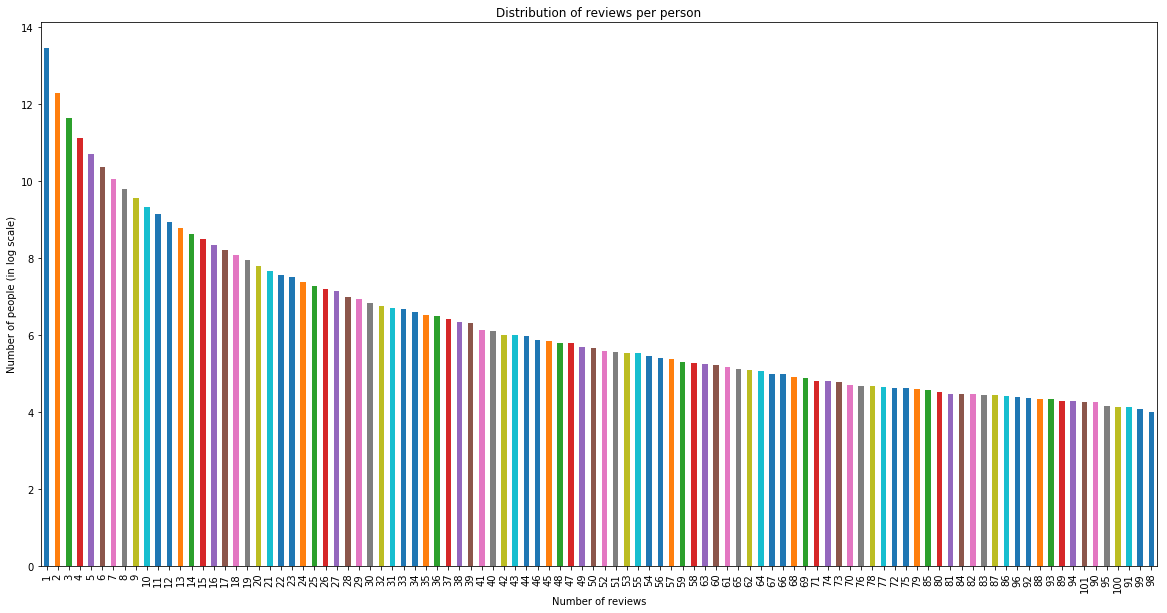

In [14]:
ax = np.log(dist_reviews[ :100]).plot(kind = 'bar', title = 'Distribution of reviews per person', figsize = (20,10))
ax.set_ylabel("Number of people (in log scale)")
ax.set_xlabel("Number of reviews")

## Person with the most reviews

In [15]:
max_rev_user_id = user.user_id[user.review_count == max(user.review_count)].values[0]
print('Name : %s' % (user.name[user.user_id == max_rev_user_id].values[0]))
print('Number of Reviews : %s' % (user.review_count[user.user_id == max_rev_user_id].values[0]))

person_most_reviews = review[review.user_id == max_rev_user_id]
print('First Review : %s' % min(person_most_reviews.date))
print('Latest Review : %s' % max(person_most_reviews.date))

Name : Victor
Number of Reviews : 11954
First Review : 2008-03-01 00:00:00
Latest Review : 2014-05-24 00:00:00


In [16]:
person_most_reviews

,business_id,date,review_id,review_stars,text,useful,user_id,review_length
5214593,6Q7-wkCPc1KF75jZLOTcMw,2011-03-25,Cg544WBUSYsJZRP_zjUYYw,1,"Decades ago, i booked low priced rooms here ...",2,8k3aO-mPeyhbR5HUucA5aA,771
5214594,J-U6C8FgveGsDdHwRB56OQ,2014-05-24,UnW63C7p_5FEAqcN9vUGgQ,1,"on or about june 25th, 2013, Global Pharmacy C...",51,8k3aO-mPeyhbR5HUucA5aA,651
5214595,ii8sAGBexBOJoYRFafF9XQ,2008-03-01,Hrlm9LvgiQTvmw0L5zOqOQ,3,i stayed here but don't remember much else. th...,0,8k3aO-mPeyhbR5HUucA5aA,344
5214596,DfgZlNgKwBvCpA_0alumXw,2008-03-01,7M8WX2FErASIRdf68r_NIQ,3,sure they give you free cohibas and cognac for...,1,8k3aO-mPeyhbR5HUucA5aA,285
5214597,z7GAft_JrFNmAH5xbVeYSA,2008-03-01,lobDkv7bYpJXuG_ZBKPOUg,3,it was pretty cheap to fly to las vegas. depen...,3,8k3aO-mPeyhbR5HUucA5aA,206
5214598,na4Th5DrNauOv-c43QQFvA,2008-03-01,idtF1AP1tlTHMVJVmX4NzQ,3,"when i was there, this place spelled elegance ...",1,8k3aO-mPeyhbR5HUucA5aA,96
5214599,u_vPjx925UPEG9DFOAAvFQ,2008-03-01,hsKnV3BM6se0VcnFM7RIMw,2,was this one of many casinos that didn't offer...,1,8k3aO-mPeyhbR5HUucA5aA,118


## Ratings

Text(0.5,0,'Rating of review')

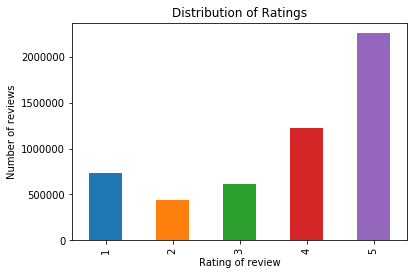

In [17]:
ax = review['review_stars'].value_counts().sort_index().plot(kind = 'bar', title = 'Distribution of Ratings')
ax.set_ylabel("Number of reviews")
ax.set_xlabel("Rating of review")

Text(0.5,0,'Average review rating')

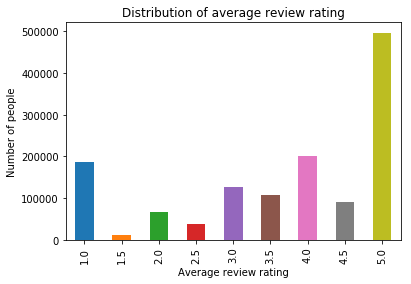

In [18]:
avg_rating_user = pd.Series(np.round(review[['review_stars', 'user_id']].groupby('user_id').mean()['review_stars'].values * 2) / 2)
ax = avg_rating_user.value_counts().sort_index().plot(kind = 'bar', title = 'Distribution of average review rating')

ax.set_ylabel("Number of people")
ax.set_xlabel("Average review rating")

In [19]:
avg_rating_user_elite = pd.Series(np.round(review[review.user_id.isin(elite_user_id)][['review_stars', 'user_id']].groupby('user_id').mean()['review_stars'].values * 2) / 2)
avg_rating_user_non_elite = pd.Series(np.round(review[~review.user_id.isin(elite_user_id)][['review_stars', 'user_id']].groupby('user_id').mean()['review_stars'].values * 2) / 2)

**Distribution of average review rating**

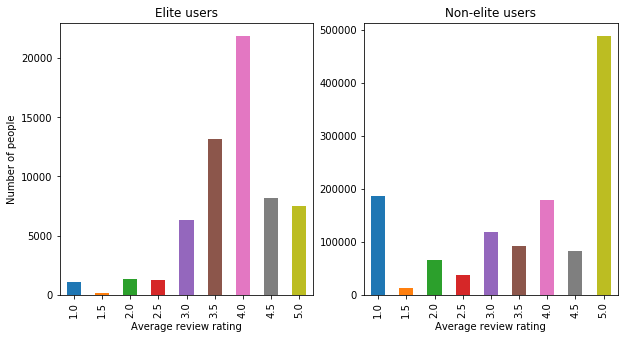

In [20]:
printmd('**Distribution of average review rating**')
plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(1, 2, 1)
ax = avg_rating_user_elite.value_counts().sort_index().plot(kind = 'bar', title = 'Elite users')
ax.set_ylabel("Number of people")
ax.set_xlabel("Average review rating")
plt.subplot(1, 2, 2)
ax1 = avg_rating_user_non_elite.value_counts().sort_index().plot(kind = 'bar', title = 'Non-elite users')
ax1.set_xlabel("Average review rating")
print()

## Most Common Business Categories

Text(0.5,0,'Business categories')

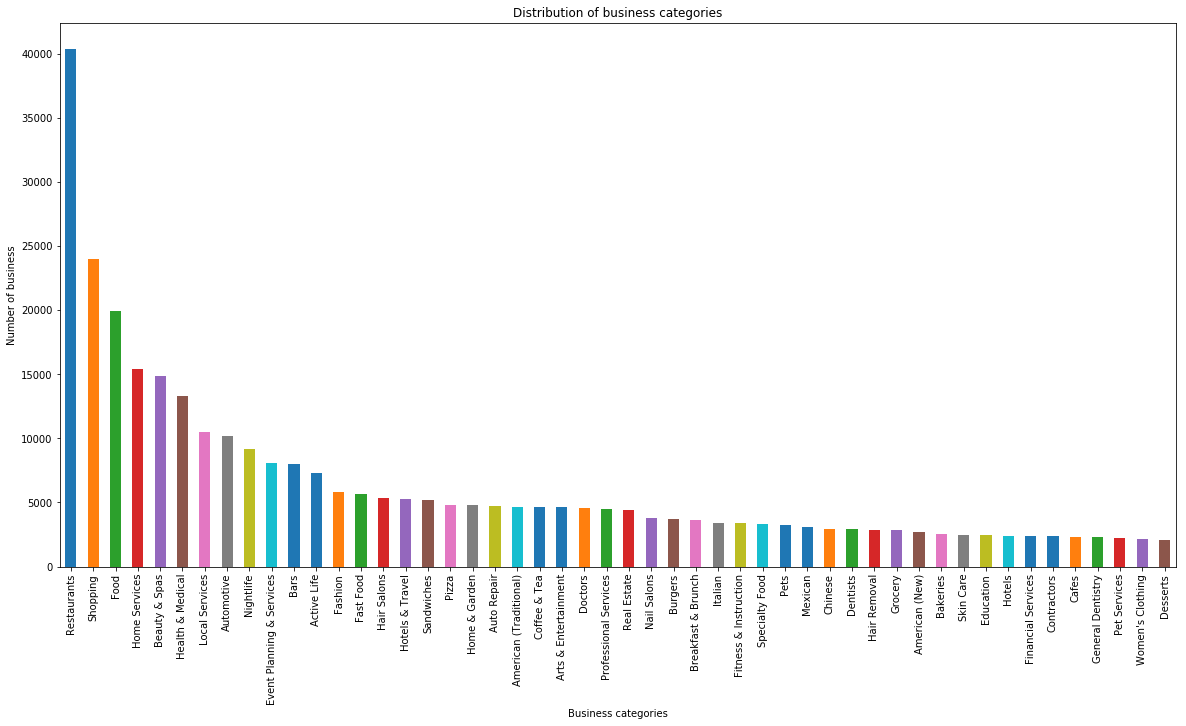

In [21]:
all_business_categories = [item for sublist in business.categories for item in sublist]
ax = pd.Series(all_business_categories).value_counts()[:50].plot(kind = 'bar', figsize = (20,10), title = 'Distribution of business categories')
ax.set_ylabel("Number of business")
ax.set_xlabel("Business categories")

## Most Reviewed Business Categories

Text(0.5,0,'Business categories')

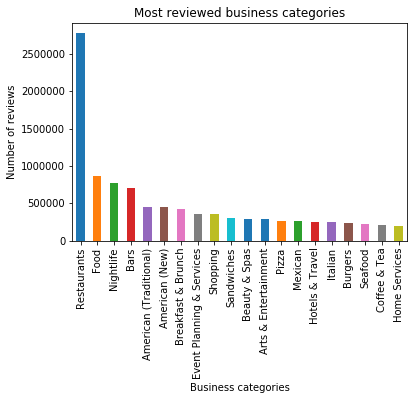

In [22]:
x = pd.get_dummies(business.categories.apply(pd.Series).stack()).sum(level = 0)
most_reviewed_places = x.apply(lambda x: np.asarray(x) * np.asarray(business.review_count[business.categories.apply(len) != 0]))
ax = most_reviewed_places.sum().sort_values(ascending = False)[:20].plot(kind = 'bar', title = 'Most reviewed business categories')
ax.set_ylabel("Number of reviews")
ax.set_xlabel("Business categories")

Text(0.5,0,'Business categories')

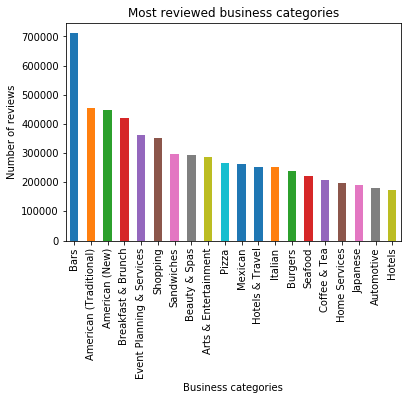

In [23]:
most_reviewed_places = x.drop(columns = ['Restaurants', 'Food', 'Nightlife']).apply(lambda x: np.asarray(x) * np.asarray(business.review_count[business.categories.apply(len) != 0]))
ax = most_reviewed_places.sum().sort_values(ascending = False)[:20].plot(kind = 'bar', title = 'Most reviewed business categories')
ax.set_ylabel("Number of reviews")
ax.set_xlabel("Business categories")

Text(0.5,0,'Business categories')

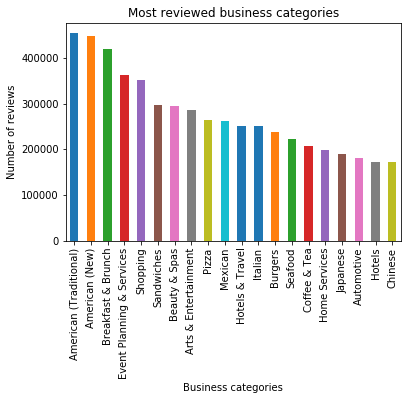

In [24]:
most_reviewed_places = x.drop(columns = ['Restaurants', 'Food', 'Nightlife', 'Bars']).apply(lambda x: np.asarray(x) * np.asarray(business.review_count[business.categories.apply(len) != 0]))
ax = most_reviewed_places.sum().sort_values(ascending = False)[:20].plot(kind = 'bar', title = 'Most reviewed business categories')
ax.set_ylabel("Number of reviews")
ax.set_xlabel("Business categories")

## Review Text Length

Text(0.5,0,'Review star rating')

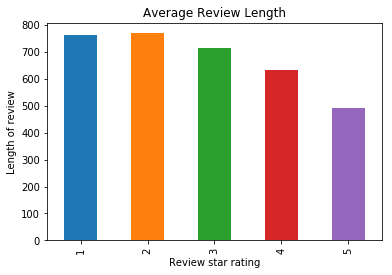

In [56]:
ax = review[['review_stars', 'review_length']].replace(0, np.NaN).groupby('review_stars').mean().review_length.plot(kind = 'bar', title = 'Average Review Length')
ax.set_ylabel("Length of review")
ax.set_xlabel("Review star rating")

In [58]:
review[['review_stars', 'review_length']].groupby('review_stars').mean().reset_index().corr()

,review_stars,review_length
review_stars,1.000000,-0.929555
review_length,-0.929555,1.000000


In [25]:
review[review.user_id.isin(elite_user_id)].review_length.mean(), review[~review.user_id.isin(elite_user_id)].review_length.mean()


(853.848392564714, 535.99569976378382)

**Across all users**

Text(0.5,0.98,'All Users')

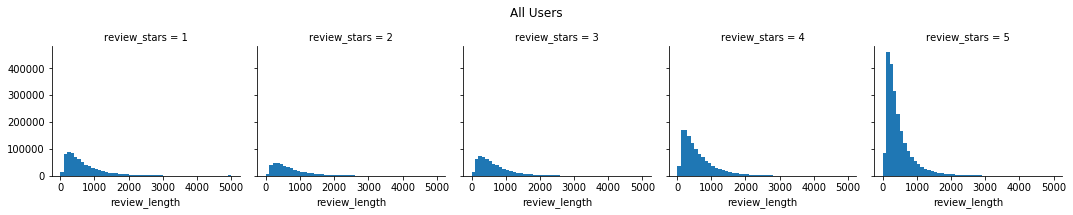

In [42]:
printmd('**Across all users**')
textSizeGraph = sns.FacetGrid(data = review, col = 'review_stars')
textSizeGraph.map(plt.hist, 'review_length', bins = 50)
plt.subplots_adjust(top=0.8)
textSizeGraph.fig.suptitle('All Users')

**Elite users**

Text(0.5,0.98,'Elite Users')

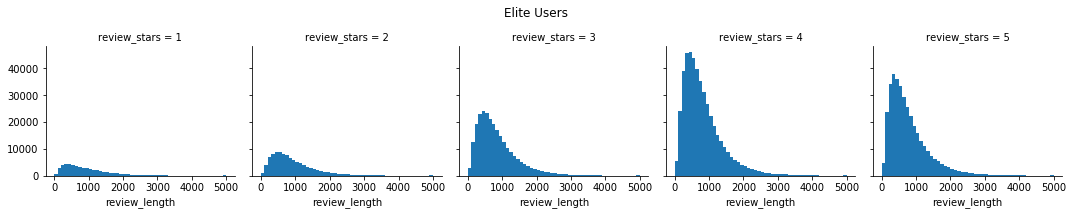

In [41]:
printmd('**Elite users**')
textSizeGraph_elite = sns.FacetGrid(data = review[review.user_id.isin(elite_user_id)], col = 'review_stars')
textSizeGraph_elite.map(plt.hist, 'review_length', bins = 50)
plt.subplots_adjust(top=0.8)
textSizeGraph_elite.fig.suptitle('Elite Users')

**Non-elite users**

Text(0.5,0.98,'Non-Elite Users')

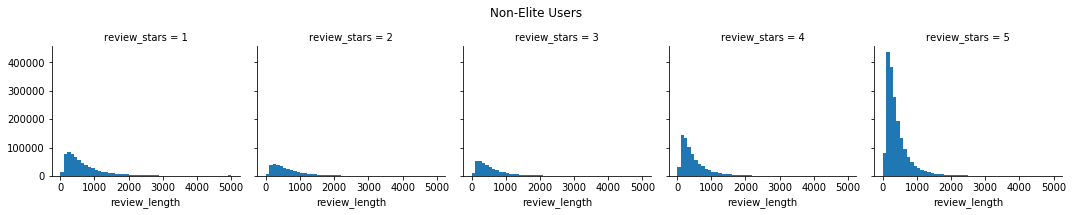

In [43]:
printmd('**Non-elite users**')
textSizeGraph_non_elite = sns.FacetGrid(data = review[~review.user_id.isin(elite_user_id)], col = 'review_stars')
textSizeGraph_non_elite.map(plt.hist, 'review_length', bins = 50)
plt.subplots_adjust(top=0.8)
textSizeGraph_non_elite.fig.suptitle('Non-Elite Users')

In [57]:
## Correlation between text length and rating
#actisns.heatmap(review.mean().corr(), annot = True)


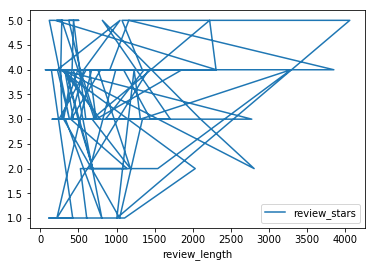

In [202]:
review[['review_stars', 'review_length']].head(100).plot(x = 'review_length', y = 'review_stars')

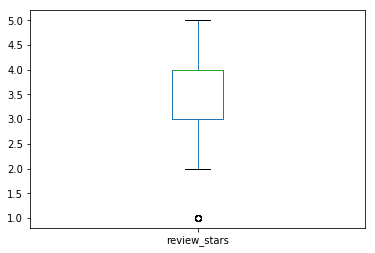

In [203]:
review[['review_stars', 'review_length']].head(100).plot(x = 'review_length', y = 'review_stars', kind = 'box')

## Dropping Records that are not part of the analysis

In [59]:
# Dropping non restaurants businesses
bus_cat_filter = business.categories.apply(lambda x: False if 'Restaurants' in x else True)
business.drop(business[bus_cat_filter].index, inplace = True)

In [60]:
# Dropping reviews of non restaurants and non-food business
rew_busniess_filter = review.business_id.isin(list(business.business_id))
review = review[rew_busniess_filter]

In [90]:
y = pd.get_dummies(business.categories.apply(pd.Series).stack()).sum(level = 0)
y = y.replace(0, np.NaN)
y['American'] = y[['American (New)','American (Traditional)']].apply(lambda row: 1 if row['American (New)'] == 1 or row['American (Traditional)'] == 1 else 0 ,axis = 1)
y.drop(columns = ['American (New)','American (Traditional)'], inplace = True)
ydf = pd.DataFrame(y.multiply(business['stars'], axis = 0).mean())
y_fil_index = y.multiply(business['stars'], axis = 0).count()[y.multiply(business['stars'], axis = 0).count() > 5].index

In [62]:
# business[business.categories.apply(lambda x: True if 'Personal Assistants' in x else False)]['categories'].values

Text(0.5,0,'Food categories')

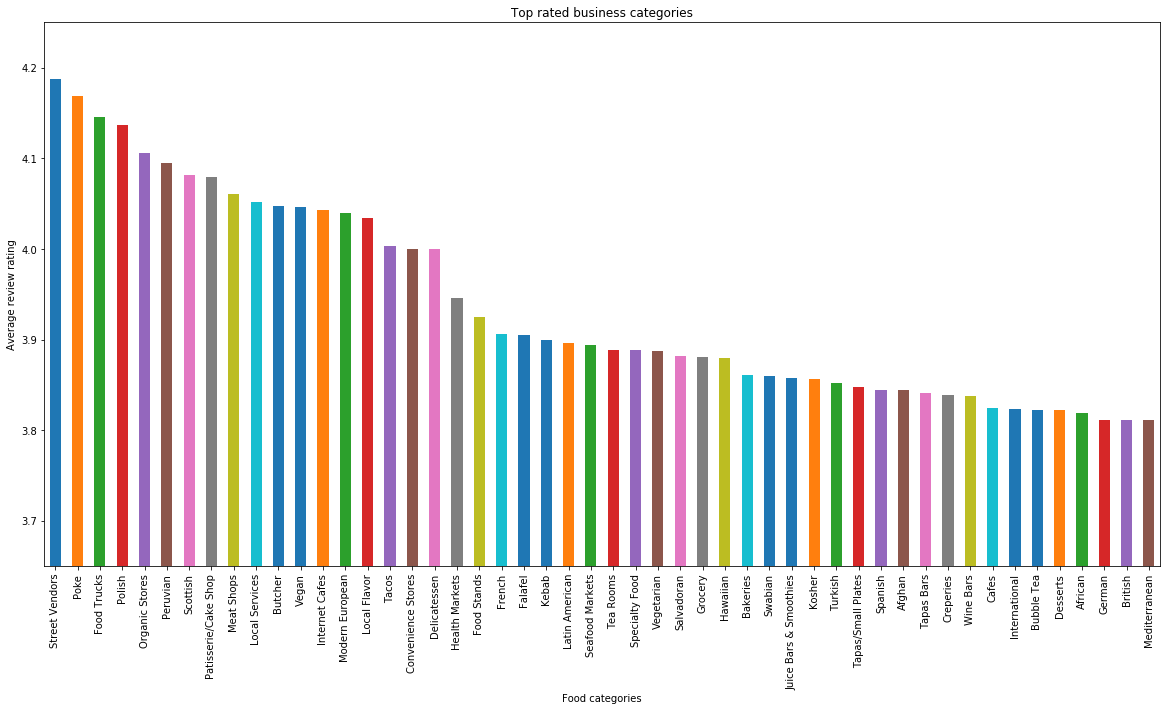

In [91]:
y_fil_index = y.multiply(business['stars'], axis = 0).count()[y.multiply(business['stars'], axis = 0).count() > 50].index
ax = ydf.loc[y_fil_index, 0].sort_values(ascending = False)[ :50].plot(kind = 'bar', figsize = (20,10), title = 'Top rated business categories')
ax.set_ylim(3.65, 4.25)
ax.set_ylabel("Average review rating")
ax.set_xlabel("Food categories")

Text(0.5,0,'Cuisines')

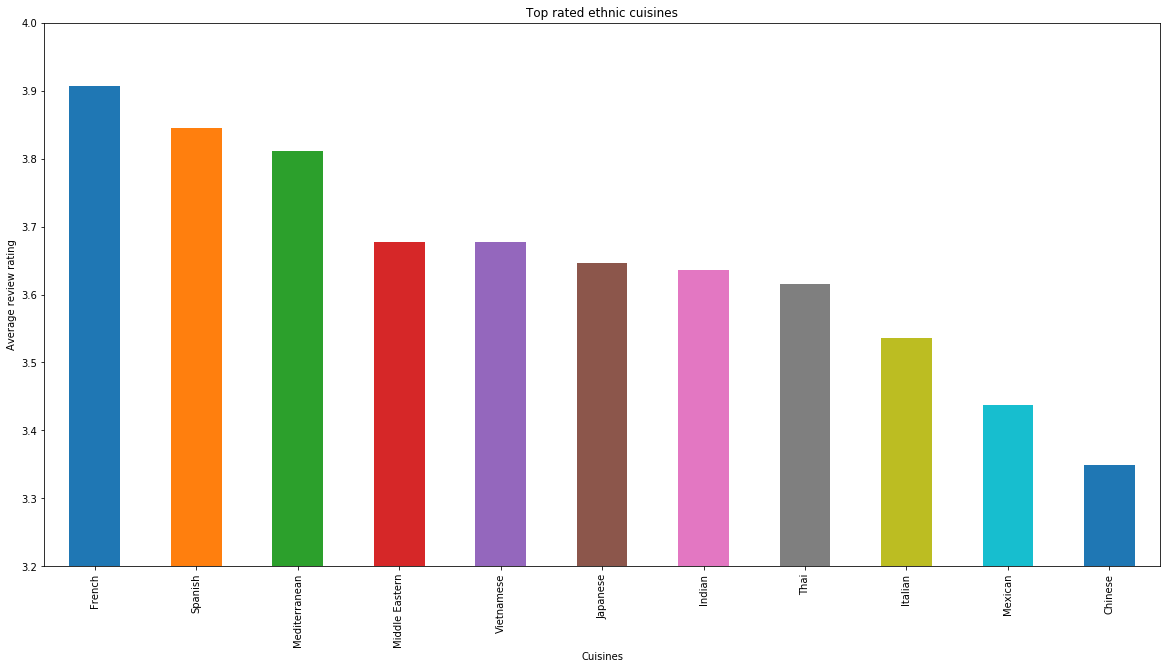

In [108]:

top_cuisines = ['Indian', 'Chinese', 'Italian', 'French', 'Japanese', 'Thai', 'Spanish', \
                'Middle Eastern', 'Vietnamese', 'Mexican', 'Mediterranean']
ax = ydf.loc[top_cuisines, 0].sort_values(ascending = False)[ :50].plot(kind = 'bar', figsize = (20,10), title = 'Top rated ethnic cuisines')
ax.set_ylim(3.2, 4)
ax.set_ylabel("Average review rating")
ax.set_xlabel("Cuisines")

# FEATURE ENGINEERING

## 1. Avg restaurant rating

In [110]:
# Avg restaurant rating
avg_restaurant_rating = review.groupby('business_id').mean()[['review_stars']]
avg_restaurant_rating.columns = ['avg_rating']
business = pd.merge(business, avg_restaurant_rating, how='inner', on=None, 
                     left_on='business_id', right_on=None,
                     left_index=False, right_index=True, sort=True,
                     suffixes=('_x', '_y'), copy=True, indicator=False,
                     validate=None)

## 2. One Hot Type Encoding of Business Categories

In [113]:
business_categories_df = pd.get_dummies(business.categories.apply(pd.Series).stack()).sum(level=0)
business_categories_counts = business_categories_df.sum().sort_values(ascending = False)

business_categories_drop = list(business_categories_counts[business_categories_counts < 10].index.values)
business_categories_drop.append('Restaurants')
business_categories_drop.append('Food')
business_categories_df.drop(columns = business_categories_drop, inplace = True)
business_categories_df['American'] = business_categories_df[['American (New)','American (Traditional)']].apply(lambda row: 1 if row['American (New)'] == 1 or row['American (Traditional)'] == 1 else 0 ,axis = 1)
business_categories_df.drop(columns = ['American (New)','American (Traditional)'], inplace = True)

business.drop(columns = ['categories'], inplace = True)
business = pd.concat([business, business_categories_df], axis=1)

business = business[business[business_categories_df.columns].sum(axis = 1) != 0]



print(business.columns, business.shape)

Index(['attributes', 'business_id', 'city', 'hours', 'name', 'neighborhood',
       'postal_code', 'review_count', 'stars', 'state',
       ...
       'Vietnamese', 'Waffles', 'Wedding Planning', 'Whiskey Bars', 'Wigs',
       'Wine & Spirits', 'Wine Bars', 'Wineries', 'Women's Clothing', 'Wraps'],
      dtype='object', length=277) (40135, 277)


Text(0.5,0,'Food categories')

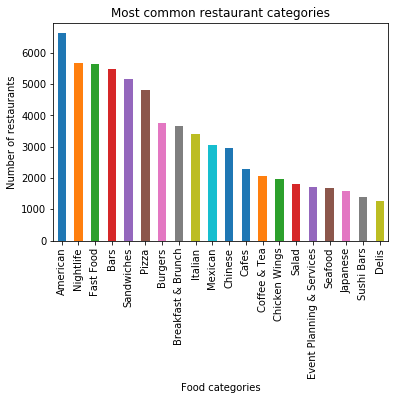

In [129]:
ax = business_categories_df.sum().sort_values(ascending = False)[:20].plot(kind = 'bar', title = 'Most common restaurant categories')
ax.set_ylabel("Number of restaurants")
ax.set_xlabel("Food categories")

In [565]:
alldf = pd.merge(business, review, how='inner', on=None, 
                     left_on='business_id', right_on='business_id',
                     left_index=False, right_index=False, sort=True,
                     suffixes=('_business', '_review'), copy=True, indicator=False,
                     validate=None)
alldf = pd.merge(alldf, user, how='inner', on=None, 
                     left_on='user_id', right_on='user_id',
                     left_index=False, right_index=False, sort=True,
                     suffixes=('', '_user'), copy=True, indicator=False,
                     validate=None)

In [567]:
user_idx = '4hEEqc04QumsW4HsWSUMxg'
 
# Lists all the cuisines that a user has reviewd
def userCategoriesRatings(user_id, cols = business_categories_df.columns):
    person_filter = alldf.user_id == user_id
    df = alldf[person_filter]
    df = df.replace(0, np.NaN)

    #top_cat = df[cols].apply(lambda x: np.asarray(x) * np.asarray(df.review_stars.values)).mean()
    top_cat = df[cols].multiply(df.review_stars, axis = 0).mean()

    return top_cat[~(top_cat.isnull())]
    
userCategoriesRatings(user_idx)

Italian    5.0
Pizza      5.0
dtype: float64

In [494]:
# Used to get extract keywords by processing all the reviews for a business
def get_business_keywords(business_id):
    df = review.loc[(review['business_id'] == business_id) & (review['review_stars'] == 5)]
    keywords_list = []
    for idx, r in df.iterrows():
        keywords_list.extend(rake.run(r.text))
    sorted_keywords = sorted(keywords_list, key=lambda tup: tup[1], reverse=True)
    
    return sorted_keywords

# Used to extract top n keywords
def extract_keywords(keyword, n = 10):
    res = []
    for i in keyword:
        if len(res) == n:
            break
        res.append(i[0])
    return res

# Used to get a user's city 
def location_visited(user_id, n = 1):
    return alldf[alldf.user_id == user_id].city.value_counts().sort_values(ascending = False)[:1].index.values

In [130]:
# Gets a list of all the businesses visited by the user
def userVisited(user_id, inverse = 0):
    if inverse == 0:
        res = review.business_id[review.user_id == user_id].unique()
    else:
        res = review.business_id[~(review.user_id == user_id)].unique()
    return res

# Gets all the cuisines of the business
def get_cuisine(business_id):
    
    xx = business[business.business_id == business_id][business_categories_df.columns.values].T
    xx.columns = ['vals']
    
    return xx[xx['vals'] == 1].index.values

In [637]:
list_col = list(business_categories_df.columns.values)
user_cat_matrix = alldf.loc[:, list_col].multiply(alldf.review_stars, axis = 0).replace(0, np.NaN)
user_cat_matrix['user_id'] = alldf.user_id
user_cat_matrix = user_cat_matrix.groupby('user_id').mean()



In [397]:
user_cat_matrix.head().replace(np.NaN, 0)

,Acai Bowls,Active Life,Adult Entertainment,Afghan,African,American (New),American (Traditional),Appliances,Arabian,Arcades,...,Vietnamese,Waffles,Wedding Planning,Whiskey Bars,Wigs,Wine & Spirits,Wine Bars,Wineries,Women's Clothing,Wraps
user_id,,,,,,,,,,,,,,,,,,,,,
---1lKK3aKOuomHnwAkAow,0.0,0.0,0.0,0.0,0.0,3.727273,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0
---PLwSf5gKdIoVnyRHgBA,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
---udAKDsn0yQXmzbWQNSw,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--0sXNBv6IizZXuV-nl0Aw,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--1av6NdbEbMiuBr7Aup9A,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Baseline Prediction

http://cs229.stanford.edu/proj2013/SawantPai-YelpFoodRecommendationSystem.pdf

In [131]:
mu = np.mean(review.review_stars)
mean_user_ratings = review[['user_id', 'review_stars']].groupby('user_id').mean()
mean_business_ratings = review[['business_id', 'review_stars']].groupby('business_id').mean()


In [132]:
def baseline_rating(user_id, business_id, mu = mu):
    bu = mean_user_ratings.loc[user_id, 'review_stars']
    bf = mean_business_ratings.loc[business_id, 'review_stars'] 
    
    bu -= mu
    bf -= mu
    
    return mu + bf + bu

baseline_rating(user_idx,'--I7YYLada0tSLkORTHb5Q')

4.7506350024207631

# Most Popular Recommendations

In [568]:
def mostPopular(user_id, limit = 10):
    
    lv = location_visited(user_id)
    top_picks = business[business.city.isin(lv)]
    

    
    places_visited = review.business_id[review.user_id == user_id]
    
    
    top_picks = top_picks[~top_picks.business_id.isin(places_visited)]
    top_picks = top_picks.sort_values('avg_rating', ascending = False)
    top_picks = top_picks[top_picks.avg_rating >= 5]
    
    print('Total available options in the location : %d' % (top_picks.shape[0]))
    
    sim_visited = pd.DataFrame(top_picks.business_id.value_counts())
    sim_visited.columns = ['Counts']
    bus_col = ['stars', 'business_id', 'name', 'city']
    bus_col.extend(business_categories_df.columns.values)
    suggestions = pd.merge(sim_visited, business[bus_col], how='inner', on=None, 
                 left_on=None, right_on='business_id',
                 left_index=True, right_index=False, sort=True,
                 suffixes=('_business', '_review'), copy=True, indicator=False,
                 validate=None)
    
    
    suggestions = suggestions[~suggestions.business_id.isin(userVisited(user_id))]
    suggestions['user_fav_cuisine'] = suggestions[userCategoriesRatings(user_id).index.values].sum(axis = 1)
    suggestions["keywords"] = suggestions.business_id.apply(get_business_keywords)
    suggestions['top_picks'] = suggestions['keywords'].apply(extract_keywords)
    suggestions['baseline_rating'] = suggestions.apply(lambda row: baseline_rating(user_id, row['business_id']), axis=1)
    suggestions.reset_index(inplace = True, drop = True)
    suggestions.drop(columns = business_categories_df.columns.values, inplace = True)
    suggestions['cuisines'] = suggestions.business_id.apply(get_cuisine)
    res = suggestions.sort_values(by = ['stars', 'user_fav_cuisine'], ascending = False).head(limit)
    res.drop(columns = ['user_fav_cuisine', 'Counts', 'business_id', 'keywords', 'top_picks', 'baseline_rating'], inplace = True)
    
    return res
    
#    return top_picks.business_id
                                         
mp_reco = mostPopular('M4yYtAXehUzaHB1ghl6EXg')

Total available options in the location : 15


In [569]:
pd.set_option('display.max_colwidth', -1)
mp_reco.index = ['Restaurant_'+str(i+1) for i in range(mp_reco.shape[0])]
mp_reco

,stars,name,city,cuisines
Restaurant_1,5.0,"The Naked Tart, LLC",Charlotte,"[Caterers, Desserts, Event Planning & Services, Gluten-Free, Health Markets, Specialty Food]"
Restaurant_2,5.0,T2C Smokehouse,Charlotte,"[Barbeque, Caterers, Event Planning & Services, Food Trucks, Party & Event Planning, Smokehouse, Steakhouses]"
Restaurant_3,5.0,La Espiga,Charlotte,"[Bakeries, Cafeteria, Comfort Food, Mexican]"
Restaurant_4,5.0,Spicy Sunshine,Charlotte,"[Caterers, Delis, Event Planning & Services, Sandwiches]"
Restaurant_5,5.0,The Cookin Coop,Charlotte,"[Breakfast & Brunch, Burgers, Fast Food, Food Trucks]"
Restaurant_6,5.0,Katz Deli,Charlotte,"[Bagels, Delis, Sandwiches, American]"
Restaurant_7,5.0,Balu's Biryani,Charlotte,"[Caterers, Event Planning & Services, Indian]"
Restaurant_8,5.0,The GyroMan,Charlotte,"[Afghan, Food Stands, Greek, Halal, Mediterranean]"
Restaurant_9,5.0,Waiter's Choice Catering,Charlotte,"[Active Life, Caterers, Event Planning & Services, Party & Event Planning, Professional Services]"
Restaurant_10,5.0,Competition Dining: Fire in the City,Charlotte,"[Arts & Entertainment, Festivals, American]"


In [452]:
printmd('## Heat Maps')

# Use this list to pick users for heatmap
#user_cat_matrix[top_cuisines].sum(axis = 1).sort_values(ascending = False)[1000:1100]

## Heat Maps

In [355]:
def sim_user_heatmap(hm_uid, n = 10, top_cuisines = top_cuisines):
    hm_person = user_cat_matrix.loc[hm_uid, top_cuisines]
    hm_others = user_cat_matrix[user_cat_matrix.index != hm_uid][top_cuisines]
    #hm_scores = hm_others.multiply(hm_person, axis = 1).sum(axis = 1) / (hm_others**2).multiply(hm_person**2, axis = 1).sum(axis = 1)
    hm_scores = hm_others.multiply(hm_person, axis = 1).sum(axis = 1)
    hm_sim_user_id = hm_scores.sort_values(ascending = False).index.values[:n]
    hm_data = user_cat_matrix.loc[hm_sim_user_id, top_cuisines].multiply(hm_person, axis = 1)
    hm_data.index = ['User'+str(i) for i in range(1, len(hm_data.index)+1)]
    sns.heatmap(hm_data, vmin = 0, vmax = 25, cmap="Blues")

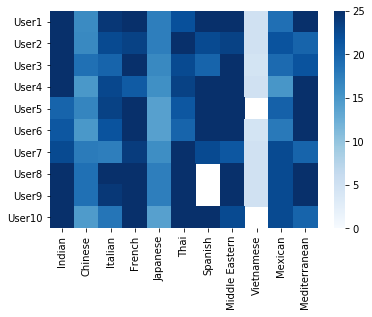

In [358]:
sim_user_heatmap('9753eOrBVUepAl3hUoHpiw')

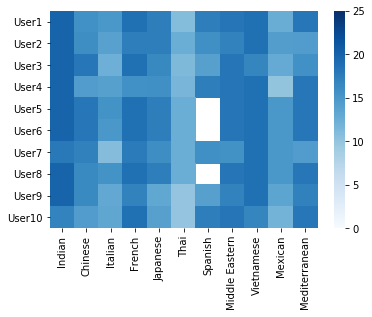

In [356]:
sim_user_heatmap('M4yYtAXehUzaHB1ghl6EXg')

# User-User Collaborative filtering:

In [584]:
# # User-User Collaborative filtering:

# def findSimilarRestaurants(user_id, user_cat_matrix = user_cat_matrix, n = 10, limit_reco = 15):
    
#     person = np.array(user_cat_matrix.loc[user_id,])[:, np.newaxis]
#     others = np.array(user_cat_matrix[user_cat_matrix.index != user_idx])
#     scores = np.sum((others * person.T), axis = 1)/ (np.sum(person*2) * np.sum(others*2, axis = 1))
#     sim_user_id = user_cat_matrix.index.values[np.argsort(-scores)[:n]]
    
#     sim_visited = []
#     for i in sim_user_id:
#         sim_visited.extend(userVisited(i))
        
#     sim_visited = pd.DataFrame(pd.Series(sim_visited).value_counts(), columns = ['Counts'])
#     bus_col = ['stars', 'business_id', 'name', 'city']
#     bus_col.extend(business_categories_df.columns.values)
    
#     suggestions = pd.merge(sim_visited, business[bus_col], how='inner', on=None, 
#                      left_on=None, right_on='business_id',
#                      left_index=True, right_index=False, sort=True,
#                      suffixes=('_business', '_review'), copy=True, indicator=False,
#                      validate=None)
    
    
    
    
#     suggestions = suggestions[~suggestions.business_id.isin(userVisited(user_idx))]
#     suggestions['user_fav_cuisine'] = suggestions[userCategoriesRatings(user_idx).index.values].sum(axis = 1)
#     suggestions["keywords"] = suggestions.business_id.apply(get_business_keywords)
#     suggestions['top_picks'] = suggestions['keywords'].apply(extract_keywords)
#     suggestions['baseline_rating'] = suggestions.apply(lambda row: baseline_rating(user_id, row['business_id']), axis=1)
#     suggestions.reset_index(inplace = True, drop = True)
    
#     return suggestions.sort_values(by = ['Counts','stars', 'user_fav_cuisine'], ascending = False).head(limit_reco)
    
# reco = findSimilarRestaurants('M4yYtAXehUzaHB1ghl6EXg', user_cat_matrix)

In [ ]:
# reco

## Mod Recos

In [570]:
#userCategoriesRatings('M4yYtAXehUzaHB1ghl6EXg')

In [732]:
# User-User Collaborative filtering:

def findSimilarRestaurants_location(user_id, user_cat_matrix = user_cat_matrix, n = 10, limit = 15):
    
    lv = location_visited(user_id)
    #bv = business.business_id[business.city.isin(lv)]
    same_city_users = alldf.user_id[alldf.city.isin(lv)].unique()
    

    person = np.array(user_cat_matrix.loc[user_id,].replace(np.NaN, 0))[:, np.newaxis]
    others = np.array(user_cat_matrix[(user_cat_matrix.index.isin(same_city_users)) & (user_cat_matrix.index != user_id)].replace(np.NaN, 0))
    scores = 1 - np.apply_along_axis(spatial.distance.cosine, 1, others, person)
    sim_user_id = user_cat_matrix[(user_cat_matrix.index.isin(same_city_users)) & (user_cat_matrix.index != user_id)].index.values[np.argsort(-scores)[:n]]
    
    sim_visited = []
    for i in sim_user_id:
        sim_visited.extend(userVisited(i))
        
    sim_visited = pd.DataFrame(pd.Series(sim_visited).value_counts(), columns = ['Counts'])
    bus_col = ['stars', 'business_id', 'name', 'city']
    bus_col.extend(business_categories_df.columns.values)
    
    
    suggestions = pd.merge(sim_visited, business[bus_col], how='inner', on=None, 
                     left_on=None, right_on='business_id',
                     left_index=True, right_index=False, sort=True,
                     suffixes=('_business', '_review'), copy=True, indicator=False,
                     validate=None)
    
    suggestions = suggestions[suggestions.city.isin(lv)]
    suggestions = suggestions[~suggestions.business_id.isin(userVisited(user_id))]
    suggestions['user_fav_cuisine'] = suggestions[userCategoriesRatings(user_id).index.values].sum(axis = 1)
    suggestions["keywords"] = suggestions.business_id.apply(get_business_keywords)
    suggestions['top_picks'] = suggestions['keywords'].apply(extract_keywords, 4)
    suggestions['baseline_rating'] = suggestions.apply(lambda row: baseline_rating(user_id, row['business_id']), axis=1)
    suggestions.reset_index(inplace = True, drop = True)
    suggestions.drop(columns = business_categories_df.columns.values, inplace = True)
    suggestions['cuisines'] = suggestions.business_id.apply(get_cuisine)
    res = suggestions.sort_values(by = ['stars', 'user_fav_cuisine'], ascending = False).head(limit)
#   res.drop(columns = ['user_fav_cuisine', 'Counts', 'business_id', 'keywords'], inplace = True)
    res.drop(columns = ['user_fav_cuisine', 'Counts', 'keywords'], inplace = True)
    #res.columns = ['Star Rating', 'Name', 'City', 'Known For', 'baseline_rating', 'cuisines']
    res.index = ['Restaurant_'+str(i+1) for i in range(res.shape[0])]
    res['eval_rating'] = [evaluation_rating(user_id,i) for i in res.business_id]
    
    return res
        
reco_mod = findSimilarRestaurants_location('M4yYtAXehUzaHB1ghl6EXg', user_cat_matrix)


In [737]:
reco_mod

,stars,business_id,name,city,top_picks,cuisines,eval_rating
Restaurant_1,5.0,jRxLnJ9my31Re_O2MvQGhw,The Tasty Bowl Subs N Such,Charlotte,"[syrafoam ice cream bowl size full, mango habenaro sauce veg rice bowl, jamaican jerk shrimp rice bowl, small chicken brown rice bowl, thai sweet chili rice bowl, nice veg rice bowl, sweet thai chili sauce, thai sweet chili sauce, curry jerk rice options, jerk chicken rice bowl]","[Caribbean, Fast Food, Indian, Italian, Mexican, Sandwiches, Thai]",4.061370
Restaurant_2,5.0,Jo1t0_Tl27ejGQO9g3GDQA,Competition Dining: Fire in the City,Charlotte,"[cast iron certified angus beef brand ribeye, holy crap nc competition dining awesomeness, yukon gold chevre puree, roasted mirepoix uncle scott, owned chapel hill cremery, secret north carolina ingredient, competition dining ticket\n2, iron chef-type event, chapel hill cremery, series puts chefs head]","[Arts & Entertainment, Festivals, American]",4.395698
Restaurant_3,5.0,3C0bnFhjkgYP9mWORKg6cA,Chili Man,Charlotte,"[discovered chili man 2 years ago, firm porch parties moving forward, homemade mango chipotle bbq sauce, offers vegan chili wednesdays complete, standard hot dog cart prices, chili man hot dog stand, charlotte gourmet hot dog movement, mac & cheese chili dog waiting, homemade bacon jam hot dog, typical jovial light fell]","[Hot Dogs, Street Vendors]",4.400150
Restaurant_4,4.5,Ls-DK3JjBChL1gZEavL7oQ,The Rogue Irish Pub,Charlotte,"[yummy chicken pot pie, blue cheese & ranch dressings, low key friendly place, frozen irish coffee, perfect sunday brunch, corned beef hash, corned beef hash, iced irish coffee, rainy snowy night, delicious comfort food]","[Bars, Breakfast & Brunch, Desserts, Gastropubs, Irish, Irish Pub, Nightlife, Sports Bars, American]",4.019547
Restaurant_5,4.5,ObcMSGc1uotvpnwydoStIg,Earl's Grocery,Charlotte,"[beer selection\n-amazing lattes\n-phenomenal staff\n-healthy pick, great concept- deli/bakery/coffee shop/fast casual restaurant/beer, gluten free options\n-great wine, pretty sizeable dining area inside, jalapeno pale ale cans selling, perfect rainy day lunch spot, gourmet green matcha tea chocolate, traditional pickled daikon & carrot strips, white lilly flour biscuit sandwich, delicious caramelized onion & rosemary scones]","[Beer, Breakfast & Brunch, Caterers, Convenience Stores, Event Planning & Services, Food Trucks, Grocery, Sandwiches, Specialty Food, Wine & Spirits]",3.893472
Restaurant_6,4.5,yt0PCCJN9hUsZhB210rsOg,The Common Market Oakwold,Charlotte,"[4th largest ceramic arts educational, offers great fresh food prepared, great community spot bringing, amazing local beer selection, made great beer recommendations, straight jacket soy wrap, original south end location, tremendous beer selection, nice outdoor area, craft beer selection]","[Bars, Beer, Coffee & Tea, Delis, Grocery, Nightlife, Sandwiches, Wine & Spirits, American]",3.664225
Restaurant_7,4.5,yBmDNVdEzW1ARUXYlKACIw,Dilworth Tasting Room,Charlotte,"[impeccable wine & soecialty beer selection, fab chateau greysac médoc, great local wine tasting room, awesome malbec made exceptional, wore harry potter earrings, love dilworth tasting room, small plate menu selections, minimal small plate menu, glorified fancy grilled cheese, big standing room area]","[Arts & Entertainment, Bars, Beer, Modern European, Nightlife, Tapas/Small Plates, Wine & Spirits, Wine Bars, Wineries]",3.761179
Restaurant_8,4.5,TZmMsbw5TbRqv8rmKj_aGg,The Common Market,Charlotte,"[deli meets corner store meets underground bar, pepper filled dragon slayer breakfast sandwich hits, buy white elephant/crazy gift exchange gifts, kombucha teas rival healthy home market, wine lovers haven -- asked specifically, a-- dj spinning records inside, performance space showcasing local talent, oddly celebrated white elephant party, great options including fresh coffee, favorite san pelligrino pomegranate aranciata]","[Arts & Entertainment, Beer, Delicatessen, Delis, Music Venues, Nightlife, Sandwiches, Win

In [753]:
#business_id = '--I7YYLada0tSLkORTHb5Q'
#user_id = user_idx

# dataSetI = [3, 45, 7, 2]
# dataSetII = [2, 54, 13, 15]
# result = 1 - spatial.distance.cosine(dataSetI, dataSetII)


def evaluation_rating(user_id, business_id):
    
    person = np.array(user_cat_matrix.loc[user_id,].replace(np.NaN, 0))[:, np.newaxis]
    same_bus_user = alldf.user_id[alldf.business_id == business_id].unique()
    others = np.array(user_cat_matrix[(user_cat_matrix.index.isin(same_bus_user))].replace(np.NaN, 0))
    scores = 1 - np.apply_along_axis(spatial.distance.cosine, 1, others, person)
    sim_user_id = user_cat_matrix[(user_cat_matrix.index.isin(same_bus_user)) & (user_cat_matrix.index != user_id)].index.values[np.argsort(-scores)[:4]]
    rating = []
    for i in get_cuisine(business_id):
        sim_others = others[np.argsort(-scores)[:4], list(user_cat_matrix.columns).index(i)]
        rating.append(np.sum(sim_others * scores[np.argsort(-scores)[:4]])/ np.sum(scores[np.argsort(-scores)[:4]]))
    if len(rating) == 0:
        return 0
    
    return np.mean(rating)
#    return person, others


## Rating Prediction

In [755]:
pred_val = alldf.iloc[:100][['user_id', 'business_id']].apply(lambda row: evaluation_rating(row['user_id'], row['business_id']), axis = 1)
true_val = alldf.iloc[:100].review_stars.values

In [760]:
pd.Series(round(pred_val) == true_val).value_counts()/100

False    0.71
True     0.29
dtype: float64

In [777]:
pred_bin = np.array([3 if (i == 4 or i == 5) else 2 if i == 3 else 1 for i in round(pred_val)])
true_bin = np.array([3 if (i == 4 or i == 5) else 2 if i == 3 else 1 for i in true_val])
pd.Series(pred_bin == true_bin).value_counts()/100


True     0.65
False    0.35
dtype: float64

## Word Cloud

In [220]:
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

stopword_mod = stopwords.words('english')
stopword_mod.append('j ai')
stopword_mod.append('c est')

In [219]:
def get_ngrams(text, n):
    res = []
    #tokens = [word.lower() for word in nltk.word_tokenize(text)]
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    filtered_tokens = filter(lambda token: token.lower() not in stopword_mod, tokens)
    for i in ngrams(filtered_tokens, n):
        res.append((' '.join(i)).lower())
    return res

#get_ngrams(review.text.values[0], 2)

**One-Star Wordcloud**

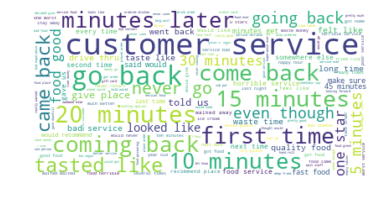

In [212]:
one_star_bigram = review.text[(review.review_stars == 1)].head(1000).apply(lambda x: get_ngrams(x, 2)).apply(pd.Series).stack().value_counts().to_dict() 

plt.figure()
wordcloud = WordCloud(background_color = 'White').generate_from_frequencies(one_star_bigram)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
printmd('**One-Star Wordcloud**')

**Two-Star Wordcloud**

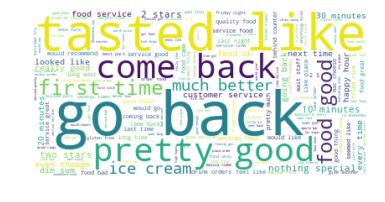

In [215]:
two_star_bigram = review.text[(review.review_stars == 2)].head(1000).apply(lambda x: get_ngrams(x, 2)).apply(pd.Series).stack().value_counts().to_dict() 

plt.figure()
wordcloud = WordCloud(background_color = 'White').generate_from_frequencies(two_star_bigram)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
printmd('**Two-Star Wordcloud**')

**Three-Star Wordcloud**

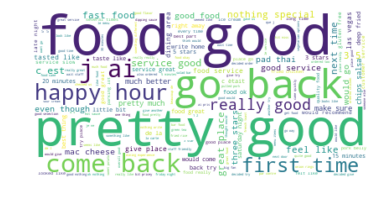

In [216]:
three_star_bigram = review.text[(review.review_stars == 3)].head(1000).apply(lambda x: get_ngrams(x, 2)).apply(pd.Series).stack().value_counts().to_dict() 

plt.figure()
wordcloud = WordCloud(background_color = 'White').generate_from_frequencies(three_star_bigram)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
printmd('**Three-Star Wordcloud**')

**Four-Star Wordcloud**

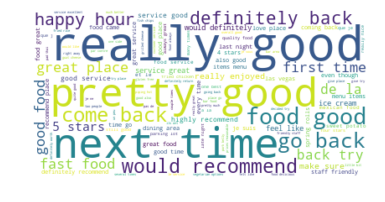

In [217]:
four_star_bigram = review.text[(review.review_stars == 4)].head(1000).apply(lambda x: get_ngrams(x, 2)).apply(pd.Series).stack().value_counts().to_dict() 

plt.figure()
wordcloud = WordCloud(background_color = 'White').generate_from_frequencies(four_star_bigram)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
printmd('**Four-Star Wordcloud**')

**Five-Star Wordcloud**

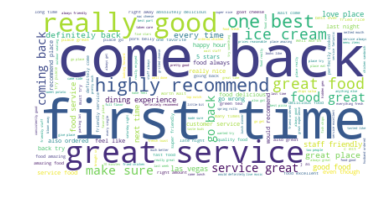

In [214]:
five_star_bigram = review.text[(review.review_stars == 5)].head(1000).apply(lambda x: get_ngrams(x, 2)).apply(pd.Series).stack().value_counts().to_dict() 

plt.figure()
wordcloud = WordCloud(background_color = 'White').generate_from_frequencies(five_star_bigram)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
printmd('**Five-Star Wordcloud**')

In [793]:
user_cat_matrix.iloc[30:35][top_cuisines].replace(np.NaN, 0)

,Indian,Chinese,Italian,French,Japanese,Thai,Spanish,Middle Eastern,Vietnamese,Mexican,Mediterranean
user_id,,,,,,,,,,,
--7gjElmOrthETJ8XqzMBw,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
--7oh57FmI8_IHX0Q4n-Wg,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0
--8ELb8W1afbyP21EZStPg,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--8EvC9O7Ycim8vCP4Cj0w,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--8NUFYnpU_Zu09TgcLevw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
